In [1]:
import torch
import datetime
import math
import matplotlib.pyplot as plt
from torch import optim
from torch import Tensor
from torch.autograd import Variable
from torch import nn
from torch.nn import functional as F
import dlc_practical_prologue 
import warnings
warnings.filterwarnings('ignore')     
#Size of the data to load
size=1000;
train_input, train_target, train_classes, test_input, test_target, test_classes = \
    dlc_practical_prologue.generate_pair_sets(size)
train_input, train_target, train_classes = Variable(train_input), Variable(train_target), Variable((train_classes))
test_input, test_target, test_classes = Variable(test_input), Variable(test_target), Variable(test_classes)

In [2]:
#getting 10 different test sets to verify each model against all of them
#the test error will be the average of the 10 test errors I get
test_input_10 = torch.Tensor(10, 2*1000, 14*14)
test_target_10 = torch.Tensor(10, 1000)
test_classes_10 = torch.Tensor(10, 2*1000)
for i in range(1,10):
    train_input, train_target, train_classes, test_input, test_target, test_classes = \
    dlc_practical_prologue.generate_pair_sets(size)
    test_input, test_target, test_classes = Variable(test_input), Variable(test_target), Variable(test_classes)
    test_input_10[i,:,:] = test_input.reshape([2000,196])
    test_target_10[i,:] = test_target
    test_classes_10[i,:] = test_classes.reshape([2000])
my_train_input = train_input.reshape([2000,196])
my_train_classes = train_classes.reshape([2000])

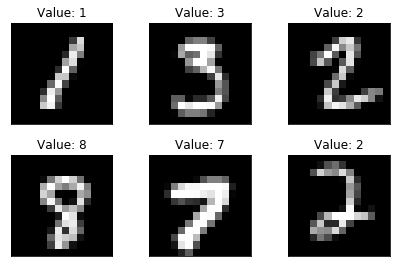

In [3]:
# displaying samples of data

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.imshow(test_input[i][0], cmap='gray', interpolation='none')
  plt.title("Value: {}".format(test_classes[i][0]))  
  plt.tight_layout()
  plt.xticks([])
  plt.yticks([])

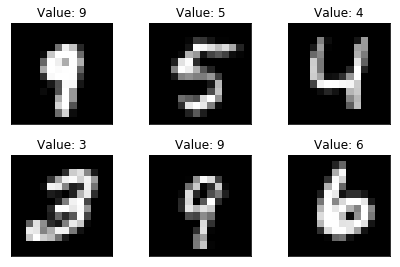

In [4]:
# displaying samples of data
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.imshow(test_input[i][1], cmap='gray', interpolation='none')
  plt.title("Value: {}".format(test_classes[i][1]))  
  plt.tight_layout()
  plt.xticks([])
  plt.yticks([])

# First neural net
Train the model on all the 2000 images in train_input

In [116]:
# device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# number of epoch
num_epochs = 25
# batch size to compute mini-batch
batch_size = 100
# number of pixels in the image 
input_size = 196
# number of possible digit: 0 to 9 
num_class = 10
# small step to find a minima
learning_rate = 0.004
# hidden size
hidden_size = 500
# p dropout
p_dropout = 0

# Fully connected neural network
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_class, dropout_p):
        super(NeuralNet, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size) 
        self.relu = nn.ReLU() 
        self.softmax = nn.Softmax()
        self.layer2 = nn.Linear(hidden_size, hidden_size)  
        self.layer3 = nn.Linear(hidden_size, num_class) 
        self.dropout = nn.Dropout(dropout_p) 
    
    def forward(self, x):
        outputs = self.layer1(x)
        outputs = self.relu(outputs)
        outputs = self.layer2(outputs)
        outputs = self.dropout(outputs)
        outputs = self.relu(outputs)
        outputs = self.layer3(outputs)
        return outputs

In [6]:
# function to train each model
def train_model(model_, my_train_input_, my_train_classes_, criterion_, optimizer_,num_epochs_,batch_size_,learning_rate_decay):
    # getting start time of train to get the train time at the end thanks to "end_time"
    start_time = datetime.datetime.now()
    # list to get train and test errors at each epoch
    train_error = []
    test_error = []
    # train function
    # Learning rate decay can be enabled or disabled than to an input in the function's parameters
    if learning_rate_decay:
        lambda_ = lambda epoch: 0.8 ** epoch
        scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer_, lr_lambda=lambda_)
    for epoch in range(1, num_epochs_+1):
        # using technique of mini batch (size of the batch in the function's parameters)
        for i in range(int(len(my_train_input_)/batch_size_)):  
            # getting images and labels in right format
            images = my_train_input_.narrow(0,i*batch_size_,batch_size_).to(device)
            labels = my_train_classes_.narrow(0,i*batch_size_,batch_size_).to(device)

            # Forward pass
            outputs = model_(images)
            loss = criterion_(outputs, labels)

            # Backward and optimize
            optimizer_.zero_grad()
            loss.backward()
            optimizer_.step()

        if learning_rate_decay:
            scheduler.step()
        # getting train error at each epoch
        train_error.append(test_accuracy(model_, my_train_input_, my_train_classes_))
        test_ = []
        # getting test errors on 10 different samples
        for i in range(1,10):
            test_.append(test_accuracy(model_, test_input_10[i,:,:], test_classes_10[i,:]))
        # getting the test error as the mean of the 10 we got
        test_error.append(sum(test_) / len(test_))
    # getting end time and training time
    end_time = datetime.datetime.now()
    training_time = end_time - start_time
    print ('Loss: {:.4f} on epoch: {}, train error: {:.5f}, avg test error on 10 different samples: {:.5f}'.format(loss.item(),epoch,train_error[-1],test_error[-1]))
    return train_error, test_error, training_time

In [7]:
def test_accuracy(model_, my_test_input_, my_test_classes_):
    total = my_test_input_.size(0)
    outputs = model_(my_test_input_)
    _, predictions = torch.max(outputs.data, 1)
    well_predicted_count = (predictions.long() == my_test_classes_.long()).sum().item()

    return 1 - well_predicted_count / total

# Testing influence of hidden size

In [9]:
batch_size, hidden_size, learning_rate, LRD, p_dropout = 20, 500, 0.004, True, 0
hidden_sizes = [10, 50, 100, 200, 500, 1000, 2000]
train_error_HS = [[],[],[],[],[],[],[]]
test_error_HS = [[],[],[],[],[],[],[]]
train_time_HS = [[],[],[],[],[],[],[]]
idx = 0
for HS in hidden_sizes:
    print("Hidden size = " + str(HS))
    model = NeuralNet(input_size, HS, num_class, p_dropout).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)  
    train_error_HS[idx], test_error_HS[idx], train_time_HS[idx] = train_model(model, my_train_input, my_train_classes, criterion, optimizer,num_epochs,batch_size,LRD)
    idx += 1

Hidden size = 10
Loss: 1.3995 on epoch: 25, train error: 0.59450, avg test error on 10 different samples: 0.59906
Hidden size = 50
Loss: 0.3142 on epoch: 25, train error: 0.09400, avg test error on 10 different samples: 0.16939
Hidden size = 100
Loss: 0.1978 on epoch: 25, train error: 0.05200, avg test error on 10 different samples: 0.14094
Hidden size = 200
Loss: 0.1473 on epoch: 25, train error: 0.02150, avg test error on 10 different samples: 0.12950
Hidden size = 500
Loss: 0.0464 on epoch: 25, train error: 0.00300, avg test error on 10 different samples: 0.10917
Hidden size = 1000
Loss: 0.0407 on epoch: 25, train error: 0.00050, avg test error on 10 different samples: 0.10533
Hidden size = 2000
Loss: 0.0180 on epoch: 25, train error: 0.00000, avg test error on 10 different samples: 0.09033


In [17]:
for i in range(len(hidden_sizes)):
    print("Train time for hidden size= {}: {} seconds".format(hidden_sizes[i],train_time_HS[i].seconds))

Train time for hidden size= 10: 1 seconds
Train time for hidden size= 50: 2 seconds
Train time for hidden size= 100: 5 seconds
Train time for hidden size= 200: 9 seconds
Train time for hidden size= 500: 26 seconds
Train time for hidden size= 1000: 75 seconds
Train time for hidden size= 2000: 226 seconds


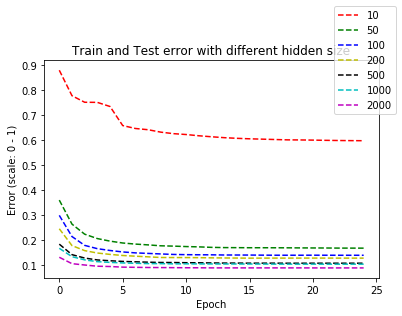

In [73]:
plt.plot(test_error_HS[0],'r--', label='10')
plt.plot(test_error_HS[1], 'g--', label='50')
plt.plot(test_error_HS[2], 'b--', label='100')
plt.plot(test_error_HS[3], 'y--', label='200')
plt.plot(test_error_HS[4], 'k--', label='500')
plt.plot(test_error_HS[5], 'c--', label='1000')
plt.plot(test_error_HS[6], 'm--', label='2000')
plt.ylabel('Error (scale: 0 - 1)')
plt.xlabel('Epoch')
plt.legend(bbox_to_anchor=(1.05, 1), loc=7, borderaxespad=0.)
plt.title("Train and Test error with different hidden size")
plt.show()

# Testing influence of Batch Size

In [67]:
batch_size, hidden_size, learning_rate, LRD, p_dropout = 20, 500, 0.004, True, 0
batch_sizes = [2, 5, 20, 50, 100]
train_error_BS = [[],[],[],[],[]]
test_error_BS = [[],[],[],[],[]]
train_time_BS = [[],[],[],[],[]]
idx = 0
for BS in batch_sizes:
    print("Batch size = " + str(BS))
    model = NeuralNet(input_size, hidden_size, num_class, p_dropout).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)  
    train_error_BS[idx], test_error_BS[idx], train_time_BS[idx] = train_model(model, my_train_input, my_train_classes, criterion, optimizer,num_epochs,BS,LRD)
    idx += 1

Batch size = 2
Loss: 0.0000 on epoch: 25, train error: 0.00050, avg test error on 10 different samples: 0.08156
Batch size = 5
Loss: 0.0001 on epoch: 25, train error: 0.00000, avg test error on 10 different samples: 0.06856
Batch size = 20
Loss: 0.0096 on epoch: 25, train error: 0.00000, avg test error on 10 different samples: 0.08889
Batch size = 50
Loss: 0.0237 on epoch: 25, train error: 0.00000, avg test error on 10 different samples: 0.09928
Batch size = 100
Loss: 0.0773 on epoch: 25, train error: 0.00400, avg test error on 10 different samples: 0.11333


In [89]:
for i in range(len(batch_sizes)):
    print("Train time for batch size= {}: {} seconds".format(batch_sizes[i],train_time_BS[i].seconds))

Train time for batch size= 2: 98 seconds
Train time for batch size= 5: 56 seconds
Train time for batch size= 20: 33 seconds
Train time for batch size= 50: 30 seconds
Train time for batch size= 100: 26 seconds


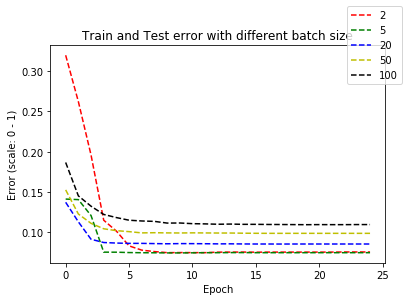

In [22]:
plt.plot(test_error_BS[0],'r--', label='2')
plt.plot(test_error_BS[1], 'g--', label='5')
plt.plot(test_error_BS[2], 'b--', label='20')
plt.plot(test_error_BS[3], 'y--', label='50')
plt.plot(test_error_BS[4], 'k--', label='100')
plt.ylabel('Error (scale: 0 - 1)')
plt.xlabel('Epoch')
plt.legend(bbox_to_anchor=(1.05, 1), loc=5, borderaxespad=0.)
plt.title("Train and Test error with different batch size")
plt.show()

# Testing the influence of learning rate decay

In [117]:
batch_size, hidden_size, learning_rate, LRD, p_dropout = 20, 500, 0.004, True, 0
learning_rate_decay = [False, True]
train_error_LRD = [[],[]]
test_error_LRD = [[],[]]
time_to_train_LRD = [[],[]]
idx = 0
for LRD in learning_rate_decay:    
    print("learning rate = " + str(LRD))
    model = NeuralNet(input_size, hidden_size, num_class, p_dropout).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate+0.001)  
    train_error_LRD[idx], test_error_LRD[idx], time_to_train_LRD[idx] = train_model(model, my_train_input, my_train_classes, criterion, optimizer,num_epochs,batch_size,LRD)
    idx += 1

learning rate = False
Loss: 0.0014 on epoch: 25, train error: 0.00000, avg test error on 10 different samples: 0.08111
learning rate = True
Loss: 0.0067 on epoch: 25, train error: 0.00000, avg test error on 10 different samples: 0.08022


In [90]:
for i in range(len(time_to_train_LRD)):
    print("Train time with learning rate decay = {}: {} seconds".format(learning_rate_decay[i],time_to_train_LRD[i].seconds))

Train time with learning rate decay = False: 7 seconds
Train time with learning rate decay = True: 7 seconds


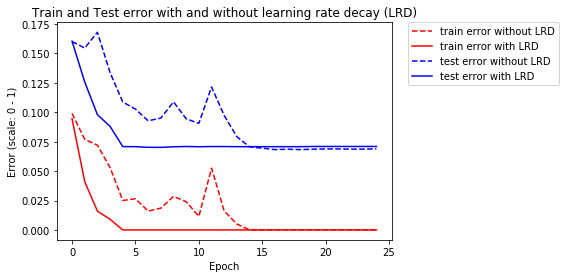

In [36]:
plt.plot(train_error_LRD[0], 'r--', label='train error without LRD')
plt.plot(train_error_LRD[1], 'r', label='train error with LRD')
plt.plot(test_error_LRD[0], 'b--', label='test error without LRD')
plt.plot(test_error_LRD[1], 'b', label='test error with LRD')
plt.ylabel('Error (scale: 0 - 1)')
plt.xlabel('Epoch')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("Train and Test error with and without learning rate decay (LRD)")
plt.show()

# Testing different learning rate values

In [38]:
batch_size, hidden_size, learning_rate, LRD, p_dropout = 20, 500, 0.004, True, 0
learning_rates = [0.0005, 0.001, 0.002, 0.004, 0.007, 0.01]
train_error_LR = [[],[],[],[],[],[]]
test_error_LR = [[],[],[],[],[],[]]
time_to_train_LR = [[],[],[],[],[],[]]
idx = 0
for LR in learning_rates:    
    print("learning rate = " + str(LRD))
    model = NeuralNet(input_size, hidden_size, num_class, p_dropout).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=LR)  
    train_error_LR[idx], test_error_LR[idx], time_to_train_LR[idx] = train_model(model, my_train_input, my_train_classes, criterion, optimizer,num_epochs,batch_size,LRD)
    idx += 1

learning rate = True
Loss: 0.0008 on epoch: 25, train error: 0.00000, avg test error on 10 different samples: 0.08522
learning rate = True
Loss: 0.0002 on epoch: 25, train error: 0.00000, avg test error on 10 different samples: 0.07289
learning rate = True
Loss: 0.0002 on epoch: 25, train error: 0.00000, avg test error on 10 different samples: 0.07622
learning rate = True
Loss: 0.0000 on epoch: 25, train error: 0.00000, avg test error on 10 different samples: 0.07089
learning rate = True
Loss: 0.0000 on epoch: 25, train error: 0.00000, avg test error on 10 different samples: 0.08217
learning rate = True
Loss: nan on epoch: 25, train error: 0.89800, avg test error on 10 different samples: 0.90094


In [91]:
for i in range(len(learning_rates)):
    print("Train time with learning rate = {}: {} seconds".format(learning_rates[i],time_to_train_LR[i].seconds))

Train time with learning rate = 0.0005: 53 seconds
Train time with learning rate = 0.001: 53 seconds
Train time with learning rate = 0.002: 52 seconds
Train time with learning rate = 0.004: 51 seconds
Train time with learning rate = 0.007: 50 seconds
Train time with learning rate = 0.01: 51 seconds


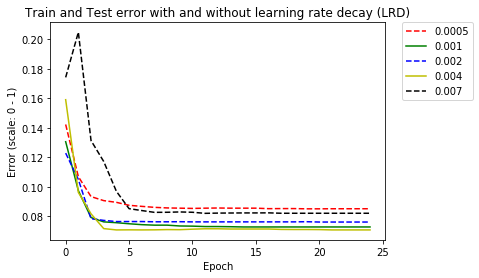

In [45]:
plt.plot(test_error_LR[0], 'r--', label='0.0005')
plt.plot(test_error_LR[1], 'g', label='0.001')
plt.plot(test_error_LR[2], 'b--', label='0.002')
plt.plot(test_error_LR[3], 'y', label='0.004')
plt.plot(test_error_LR[4], 'k--', label='0.007')
plt.ylabel('Error (scale: 0 - 1)')
plt.xlabel('Epoch')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("Train and Test error with and without learning rate decay (LRD)")
plt.show()

# Testing regularization technique: Dropout

In [94]:
batch_size, hidden_size, learning_rate, LRD, p_dropout = 20, 2000, 0.004, True, 0
dropouts = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
idx = 0
train_error_dropout = [[],[],[],[],[],[],[],[]]
test_error_dropout = [[],[],[],[],[],[],[],[]]
train_time_dropout = [[],[],[],[],[],[],[],[]]
for dropout_ in dropouts:
    print("Dropout= " + str(dropout_))
    model = NeuralNet(input_size, hidden_size, num_class, dropout_).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)  
    train_error_dropout[idx], test_error_dropout[idx], train_time_dropout[idx] = train_model(model, my_train_input, my_train_classes, criterion, optimizer,num_epochs,batch_size,LRD)
    idx += 1

Dropout= 0
Loss: 0.0024 on epoch: 25, train error: 0.00000, avg test error on 10 different samples: 0.07061
Dropout= 0.1
Loss: 0.0020 on epoch: 25, train error: 0.00000, avg test error on 10 different samples: 0.07283
Dropout= 0.2
Loss: 0.0016 on epoch: 25, train error: 0.00000, avg test error on 10 different samples: 0.07367
Dropout= 0.3
Loss: 0.0032 on epoch: 25, train error: 0.00050, avg test error on 10 different samples: 0.07933
Dropout= 0.4
Loss: 0.0075 on epoch: 25, train error: 0.00100, avg test error on 10 different samples: 0.07961
Dropout= 0.5
Loss: 0.0195 on epoch: 25, train error: 0.00150, avg test error on 10 different samples: 0.08222
Dropout= 0.6
Loss: 0.0585 on epoch: 25, train error: 0.00250, avg test error on 10 different samples: 0.09022
Dropout= 0.7
Loss: 0.0019 on epoch: 25, train error: 0.01000, avg test error on 10 different samples: 0.09167


In [106]:
for i in range(len(dropouts)):
    print("Train time for dropout= {}: {} minutes".format(dropouts[i],train_time_dropout[i].seconds//60))

Train time for dropout= 0: 5 minutes
Train time for dropout= 0.1: 5 minutes
Train time for dropout= 0.2: 5 minutes
Train time for dropout= 0.3: 5 minutes
Train time for dropout= 0.4: 5 minutes
Train time for dropout= 0.5: 5 minutes
Train time for dropout= 0.6: 5 minutes
Train time for dropout= 0.7: 5 minutes


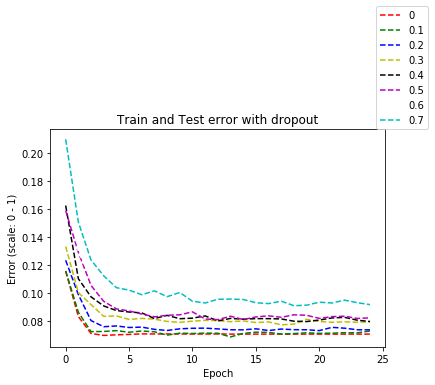

In [99]:
plt.plot(test_error_dropout[0],'r--', label='0')
plt.plot(test_error_dropout[1], 'g--', label='0.1')
plt.plot(test_error_dropout[2], 'b--', label='0.2')
plt.plot(test_error_dropout[3], 'y--', label='0.3')
plt.plot(test_error_dropout[4], 'k--', label='0.4')
plt.plot(test_error_dropout[5], 'm--', label='0.5')
plt.plot(test_error_dropout[6], 'w--', label='0.6')
plt.plot(test_error_dropout[7], 'c--', label='0.7')
plt.ylabel('Error (scale: 0 - 1)')
plt.xlabel('Epoch')
plt.legend(bbox_to_anchor=(1.05, 1), loc=8, borderaxespad=0.)
plt.title("Train and Test error with dropout")
plt.show()

# Comparing Neural nets with 3, 4 and 5 layers

In [112]:
# Fully connected neural network
class NeuralNet4(nn.Module):
    def __init__(self, input_size, hidden_size, num_class, dropout_p):
        super(NeuralNet4, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size) 
        self.relu = nn.ReLU()
        self.layer2 = nn.Linear(hidden_size, hidden_size) 
        self.layer3 = nn.Linear(hidden_size, hidden_size)  
        self.layer4 = nn.Linear(hidden_size, num_class) 
        self.dropout = nn.Dropout(dropout_p) 
    
    def forward(self, x):
        outputs = self.layer1(x)
        outputs = self.relu(outputs)
        outputs = self.layer2(outputs)
        outputs = self.dropout(outputs)
        outputs = self.relu(outputs)
        outputs = self.layer3(outputs)
        outputs = self.dropout(outputs)
        outputs = self.relu(outputs)
        outputs = self.layer4(outputs)
        return outputs
    
# Fully connected neural network
class NeuralNet5(nn.Module):
    def __init__(self, input_size, hidden_size, num_class, dropout_p):
        super(NeuralNet5, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size) 
        self.relu = nn.ReLU()
        self.layer2 = nn.Linear(hidden_size, hidden_size) 
        self.layer3 = nn.Linear(hidden_size, hidden_size) 
        self.layer4 = nn.Linear(hidden_size, hidden_size)  
        self.layer5 = nn.Linear(hidden_size, num_class) 
        self.dropout = nn.Dropout(dropout_p) 
    
    def forward(self, x):
        outputs = self.layer1(x)
        outputs = self.relu(outputs)
        outputs = self.layer2(outputs)
        outputs = self.dropout(outputs)
        outputs = self.relu(outputs)
        outputs = self.layer3(outputs)
        outputs = self.dropout(outputs)
        outputs = self.relu(outputs)
        outputs = self.layer4(outputs)
        outputs = self.dropout(outputs)
        outputs = self.relu(outputs)
        outputs = self.layer5(outputs)
        return outputs

In [118]:
batch_size, hidden_size, learning_rate, LRD, p_dropout = 5, 2000, 0.004, True, 0

model = NeuralNet(input_size, hidden_size, num_class, p_dropout).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)  
train_error3, test_error3, train_time3 = train_model(model, my_train_input, my_train_classes, criterion, optimizer,num_epochs,batch_size,LRD)
    

Loss: 0.0003 on epoch: 25, train error: 0.00000, avg test error on 10 different samples: 0.06511


In [119]:
# neural net 4 layers
model4 = NeuralNet4(input_size, hidden_size, num_class, p_dropout).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model4.parameters(), lr=learning_rate)  
train_error4, test_error4, train_time4 = train_model(model4, my_train_input, my_train_classes, criterion, optimizer,num_epochs,batch_size,LRD)
    

Loss: 0.0001 on epoch: 25, train error: 0.00000, avg test error on 10 different samples: 0.06056


In [120]:
# neural net 5 layers
model5 = NeuralNet5(input_size, hidden_size, num_class, p_dropout).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model5.parameters(), lr=learning_rate)  
train_error5, test_error5, train_time5 = train_model(model5, my_train_input, my_train_classes, criterion, optimizer,num_epochs,batch_size,LRD)
    

Loss: 0.0000 on epoch: 25, train error: 0.00000, avg test error on 10 different samples: 0.06450


In [121]:
print("Train time for 3 layers: {} minutes".format(train_time3.seconds//60))
print("Train time for 4 layers: {} minutes".format(train_time4.seconds//60))
print("Train time for 5 layers: {} minutes".format(train_time5.seconds//60))

Train time for 3 layers: 8 minutes
Train time for 4 layers: 17 minutes
Train time for 5 layers: 24 minutes


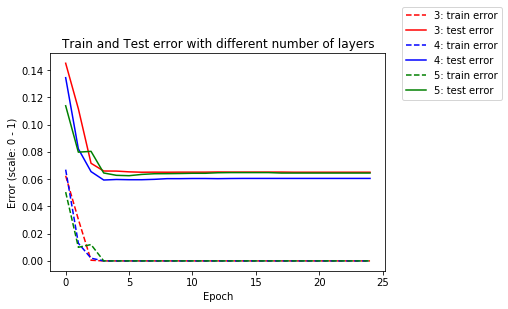

In [122]:
plt.plot(train_error3,'r--', label='3: train error')
plt.plot(test_error3, 'r', label='3: test error')
plt.plot(train_error4, 'b--', label='4: train error')
plt.plot(test_error4,'b', label='4: test error')
plt.plot(train_error5, 'g--', label='5: train error')
plt.plot(test_error5, 'g', label='5: test error')
plt.ylabel('Error (scale: 0 - 1)')
plt.xlabel('Epoch')
plt.legend(bbox_to_anchor=(1.05, 1), loc=6, borderaxespad=0.)
plt.title("Train and Test error with different number of layers")
plt.show()

# Testing on the 2 batches
A model for the two batch of 1000 images

In [124]:
my_test_input1 = test_input[:,0,:]
my_test_input2 = test_input[:,1,:]
my_test_classes1 = test_classes[0:1000,0]
my_test_classes2 = test_classes[0:1000,1]

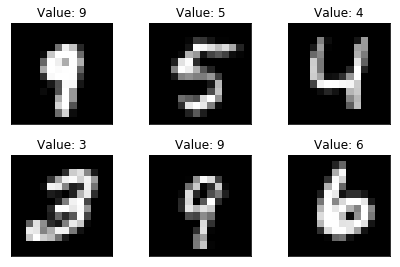

In [125]:
# verifying the digits and labels
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.imshow(my_test_input2[i], cmap='gray', interpolation='none')
  plt.title("Value: {}".format(my_test_classes2[i]))  
  plt.tight_layout()
  plt.xticks([])
  plt.yticks([])

In [126]:
my_test_input1=my_test_input1.reshape(1000,196)
my_test_input2=my_test_input2.reshape(1000,196)

In [135]:
print("Error on batch 1: {}".format(test_accuracy(model4, my_test_input1, my_test_classes1)))
print("Error on batch 2: {}".format(test_accuracy(model4, my_test_input2, my_test_classes2)))

Error on batch 1: 0.07299999999999995
Error on batch 2: 0.05600000000000005


# Building neural net for Digit Comparison

In [128]:
# number of epoch
num_epochs_dc = 21
# batch size to compute mini-batch
batch_size_dc = 10
# number of pixels in the image 
input_size_dc = 2
# number of possible digit: 0 to 9 
num_class_dc = 1
# small step to find a minima
learning_rate_dc = 0.004
# hidden size
hidden_size_dc = 200

# Fully connected neural network
class NeuralNet_dc(nn.Module):
    def __init__(self, input_size, hidden_size, num_class):
        super(NeuralNet_dc, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size) 
        self.relu = nn.ReLU()
        self.layer2 = nn.Linear(hidden_size, hidden_size)  
        self.layer3 = nn.Linear(hidden_size, num_class)  
    
    def forward(self, x, batch_size_):
        outputs = self.layer1(x)
        outputs = self.relu(outputs)
        outputs = self.layer2(outputs)
        outputs = self.relu(outputs)
        outputs = self.layer3(outputs)
        return outputs.reshape([1, batch_size_])[0]
        
    
# creating neural net
model_dc = NeuralNet_dc(input_size_dc, hidden_size_dc, num_class_dc).to(device)

# MSELoss and optimizer which minimize loss with learning rate step
criterion_dc = nn.MSELoss()
optimizer_dc = torch.optim.SGD(model_dc.parameters(), lr=learning_rate_dc)  

# training
for epoch in range(num_epochs_dc):
    for i in range(int(len(train_classes)/batch_size_dc)):  
        inputs = train_classes.narrow(0,i*batch_size_dc,batch_size_dc).to(device).float()
        labels = train_target.narrow(0,i*batch_size_dc,batch_size_dc).to(device)

        # Forward pass
        outputs = model_dc(inputs,batch_size_dc)
        loss = criterion_dc(outputs, labels.float())
        
        # Backward and optimize
        optimizer_dc.zero_grad()
        loss.backward()
        optimizer_dc.step()
    if(epoch % 5 == 0):    
        print ('Loss: {:.4f} on epoch: {}'.format(loss.item(),epoch+1))

Loss: 0.1193 on epoch: 1
Loss: 0.0349 on epoch: 6
Loss: 0.0198 on epoch: 11
Loss: 0.0128 on epoch: 16
Loss: 0.0088 on epoch: 21


In [129]:
# testing
def test_accuracy_dc(model_, my_test_input_, my_test_classes_):

    total = my_test_input_.size(0)

    outputs = model_(my_test_input_.float(),total)
    t = Variable(torch.Tensor([0.5]))
    predictions = (outputs > t).float() * 1

    well_predicted_count = (predictions == my_test_classes_.float()).sum().item()
    print('Accuracy: {} %'.format(100 * well_predicted_count / total))

test_accuracy_dc(model_dc, test_classes, test_target)


Accuracy: 100.0 %


# Running both neural networks in sequence

In [131]:
# getting y from test input
def getting_y(model_, my_test_input_, my_test_classes_):
    total = my_test_input_.size(0)
    outputs = model_(my_test_input_)
    _, predictions = torch.max(outputs.data, 1)
    well_predicted_count = (predictions == my_test_classes_).sum().item()

    print('Accuracy: {} %'.format(100 * well_predicted_count / total))
    return predictions

y1 = getting_y(model4, my_test_input1, my_test_classes1)
y2 = getting_y(model4, my_test_input2, my_test_classes2)
y_test_classes = torch.tensor([y1.tolist(), y2.tolist()]).transpose_(0, 1)
y_test_classes

Accuracy: 92.7 %
Accuracy: 94.4 %


tensor([[1, 9],
        [3, 5],
        [2, 4],
        ...,
        [4, 9],
        [3, 5],
        [2, 0]])

In [136]:
# getting final accuracy
def digit_comparison(model_, my_test_input_, my_test_classes_):
    total = my_test_input_.size(0)

    outputs = model_(my_test_input_.float())
    t = Variable(torch.Tensor([0.5]))
    predictions = (outputs > t).float() * 1

    well_predicted_count = (predictions == my_test_classes_.float()).sum().item()
    print('Accuracy: {} %'.format(100 * well_predicted_count / total))

test_accuracy_dc(model_dc, y_test_classes, test_target)

Accuracy: 95.8 %
